In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
sns.set(rc={'figure.figsize':(12,8)})
pd.options.display.max_rows=None

In [5]:
titles = ['Mr','Miss','Mrs','Jr','Dr','Rev','Master','Mme','Major','Ms','Mlle','Jonkheer','Don','Col','Capt','Countess']
class CustomeOneHotEncoder:
    def __init__(self,drop=False):
        self.columns_ = None
        self.drop_ = drop
        self.encoder = OneHotEncoder()
        
    def fit(self,data,columns):
        self.columns_ = columns
        self.encoder.fit(data[self.columns_])
    
    def fit_transform(self,data,columns):
        self.fit(data,columns)
        return self.transform(data)
    
    def transform(self,data):
        feature_array = self.encoder.transform(data[self.columns_]).toarray()
        feature_label = self.encoder.categories_
        new_feature_label = []
        for x,y in zip(self.columns_,feature_label):
            new_feature_label.append([x+'_'+str(z) for z in y])

        final_feature_label= np.concatenate([x for x in new_feature_label])
        encoded_df = pd.DataFrame(feature_array,columns=final_feature_label,index = data.index)

        if self.drop_:
            cols_to_drop = [x[0] for x in new_feature_label]
            encoded_df = encoded_df.drop(cols_to_drop,axis=1)
        data = data.drop(columns,axis=1)   
        #return encoded_df
        return pd.concat([data,encoded_df],axis=1)
    
def get_title(name,title=titles):
    if any(t in name for t in title):
        for tt in title:
            if name.find(tt) != -1:
                return tt
    else:
        return name
    
def transform_age(dataset):
    if not math.isnan(dataset.Age):
        return dataset.Age
    if dataset.Pclass == 1:
        if dataset.Sex == 'male':
            return 40
        else:
            return 35
    elif dataset.Pclass == 2:
        if dataset.Sex == 'male':
            return 30
        else:
            return 28
    else:
        if dataset.Sex == 'male':
            return 24
        else:
            return 22
            
    
def extract_cabin(cabin):
    if cabin == cabin:
        return cabin.split()[0][0]
    else:
        return 'No_Cabin'    
    
def get_age_group(age):
    if age <=1:
        return 1
    elif age >1 and age < 20:
        return 2
    elif age >=20 and age < 40:
        return 3
    elif age >=40 and age <60:
        return 4
    else:
        return 5
    
def get_fair_per_person(data):
    if data.Total_Members == 0:
        return data.Fare
    else:
        return data.Fare/(data.Total_Members+1)
'''
def process_cabin(data,fornull=True):
    if fornull:
        cabin_data = data[(data['Cabin'].isnull())]
    else:
        cabin_data = data[~(data['Cabin'].isnull())]
    y = cabin_data['Cabin_Codes']
    x = cabin_data[['Age','SibSp','Parch','Fare','Pclass','Sex','Age_Group','Title']]
    x.Age = x.apply(transform_age,axis=1)
    
    return x,y,cabin_data
'''    

"\ndef process_cabin(data,fornull=True):\n    if fornull:\n        cabin_data = data[(data['Cabin'].isnull())]\n    else:\n        cabin_data = data[~(data['Cabin'].isnull())]\n    y = cabin_data['Cabin_Codes']\n    x = cabin_data[['Age','SibSp','Parch','Fare','Pclass','Sex','Age_Group','Title']]\n    x.Age = x.apply(transform_age,axis=1)\n    \n    return x,y,cabin_data\n"

# Data Preprocessing Train Data

In [6]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data['Total_Members'] = data['SibSp']+data['Parch']
data['Title'] = data['Name'].apply(get_title)
data['Title'].unique()
data['Cabin_Codes'] = data['Cabin'].apply(extract_cabin)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Total_Members,Title,Cabin_Codes
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,No_Cabin
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mr,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,No_Cabin
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mr,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,No_Cabin


In [8]:
data['Age'] = data.apply(transform_age,axis=1)
data['Age_Group'] = data['Age'].apply(get_age_group)
data['Multiply'] = data['Pclass']*data['Age']
data['fare_per_person'] = data.apply(get_fair_per_person,axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Total_Members,Title,Cabin_Codes,Age_Group,Multiply,fare_per_person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,No_Cabin,3,66.0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mr,C,3,38.0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,No_Cabin,3,78.0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mr,C,3,35.0,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,No_Cabin,3,105.0,8.05000


In [9]:
data = data.drop(['Ticket','Name','Cabin'],axis=1)
data['Embarked'] = data['Embarked'].fillna(method='ffill')
data.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
Total_Members      0
Title              0
Cabin_Codes        0
Age_Group          0
Multiply           0
fare_per_person    0
dtype: int64

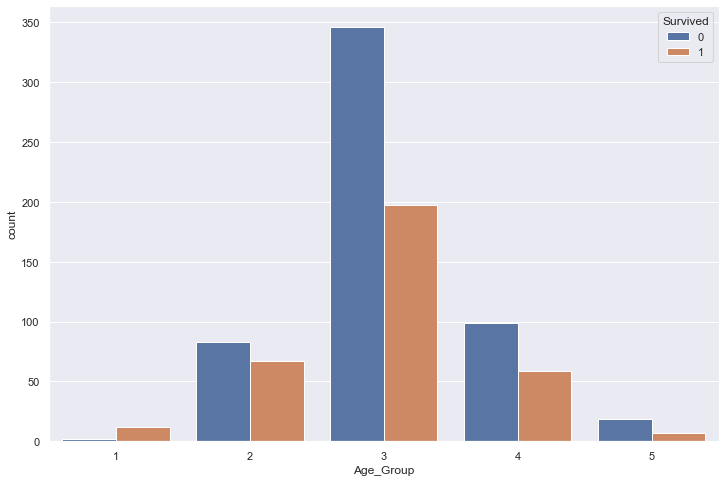

In [10]:
sns.countplot(data['Age_Group'],hue=data['Survived'])

In [11]:
data.to_csv('train_1.csv',index=False)

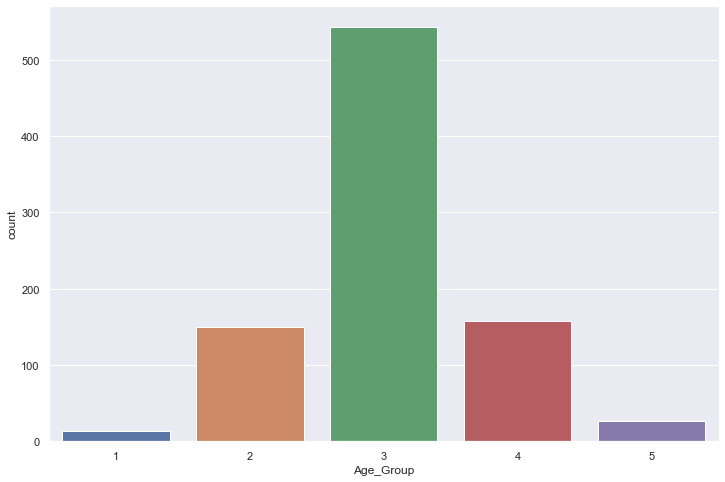

In [12]:
sns.countplot(data['Age_Group'])

# Data Processing test

In [13]:
t_data = pd.read_csv('test.csv')
test_data = t_data.copy()
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [14]:
test_data.Age = test_data.apply(transform_age,axis=1)
test_data['Fare'] = test_data['Fare'].fillna(method='ffill')
test_data['Cabin_Codes'] = test_data['Cabin'].apply(extract_cabin)
test_data['Age_Group'] = test_data['Age'].apply(get_age_group)
test_data['Title'] = test_data['Name'].apply(get_title)
test_data['Total_Members'] = test_data['SibSp']+test_data['Parch']
test_data['Multiply'] = test_data['Pclass']*test_data['Age']
test_data['fare_per_person'] = test_data.apply(get_fair_per_person,axis=1)
test_data = test_data.drop(['Ticket','Name','Cabin'],axis=1)
print(test_data.isnull().sum())
print(test_data.head())

passenger_id = test_data.PassengerId

PassengerId        0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
Cabin_Codes        0
Age_Group          0
Title              0
Total_Members      0
Multiply           0
fare_per_person    0
dtype: int64
   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
0          892       3    male  34.5      0      0   7.8292        Q   
1          893       3  female  47.0      1      0   7.0000        S   
2          894       2    male  62.0      0      0   9.6875        Q   
3          895       3    male  27.0      0      0   8.6625        S   
4          896       3  female  22.0      1      1  12.2875        S   

  Cabin_Codes  Age_Group Title  Total_Members  Multiply  fare_per_person  
0    No_Cabin          3    Mr              0     103.5         7.829200  
1    No_Cabin          4    Mr              1     141.0         3.500000  
2    No_Cabin          5    Mr     

In [15]:
test_data.to_csv('test_1.csv',index=False)